In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.impute import KNNImputer

In [2]:
train_set = pd.read_csv('train_prepared.csv', encoding='utf-8')
test_set = pd.read_csv('test_prepared.csv', encoding='utf-8')

train_set = train_set.replace([-np.inf, np.inf], np.nan)
test_set = test_set.replace([-np.inf, np.inf], np.nan)

#train_fts = train_set.columns

#imputer_train = KNNImputer()
#imputer_train.fit(train_set)
#train_set = pd.DataFrame(imputer_train.transform(train_set))

#train_set.columns = train_fts

#X_test_fts = test_set.columns

#imputer_test = KNNImputer()
#imputer_test.fit(test_set)
#test_set = pd.DataFrame(imputer_test.transform(test_set))

#test_set.columns=X_test_fts

In [3]:
X = train_set.drop(columns=['Opportunity_ID', 'Target'])
y = train_set.Target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [5]:
model = LogisticRegression()

random_search = RandomizedSearchCV(model, space, n_iter=100, \
                                   scoring='neg_log_loss', n_jobs=-1, cv=5, random_state=1, verbose=3)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.8s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020FA255CD90>,
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=1, scoring='neg_log_loss', verbose=3)

In [6]:
random_search.best_params_

{'C': 2.976522963488366, 'penalty': 'l1', 'solver': 'liblinear'}

In [4]:
best = {'C': 1.8017093069504055, 'penalty': 'l1', 'solver': 'liblinear'}

lr = LogisticRegression(**best, max_iter=1000)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer

numeric_cols = X_train.select_dtypes(include=['int', 'float64']).columns.to_list()
#numeric_cols = ['Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD']

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer()),
                            ('scaler', StandardScaler())
                        ]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                        ],
                    remainder='passthrough'
                    )

In [6]:
pipe = Pipeline([('preprocessing', preprocessor),('lr',lr)])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
pipe.fit(X=X_train, y=y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Convertibility',
                                                   'Total_Amount_Sum_USD',
                                                   'Total_Taxable_Amount_USD',
                                                   'Year_Creation',
                                                   'Month_Creation',
                                                   'Year_Delivery',
                                                   'Month_Delivery',
                    

In [7]:
log_loss(y_test, pipe.predict_proba(X_test))

0.4372136936290706

In [8]:
from sklearn.metrics import f1_score

f1_score(y_test, pipe.predict(X_test))

0.825469537333944

In [9]:
log_loss(y_train, pipe.predict_proba(X_train))

0.4197473128891458

In [10]:
f1_score(y_train, pipe.predict(X_train))

0.8189645005307229

In [14]:
pp = pipe.predict_proba(test_set.drop(columns=['Opportunity_ID']))[:, 1]
pp

array([0.85540089, 0.82891371, 0.54045154, ..., 0.42949535, 0.64311986,
       0.11238814])

In [15]:
target = pd.DataFrame(pp)
target.columns=['Target']
target

,Target
0,0.855401
1,0.828914
2,0.540452
3,0.554066
4,0.865949
...,...
1562,0.877435
1563,0.433121
1564,0.429495
1565,0.643120


In [16]:
target['Opportunity_ID'] = test_set.Opportunity_ID.to_list()
target.loc[:, ['Opportunity_ID', 'Target']].to_csv('predictions/lr_pred.csv')

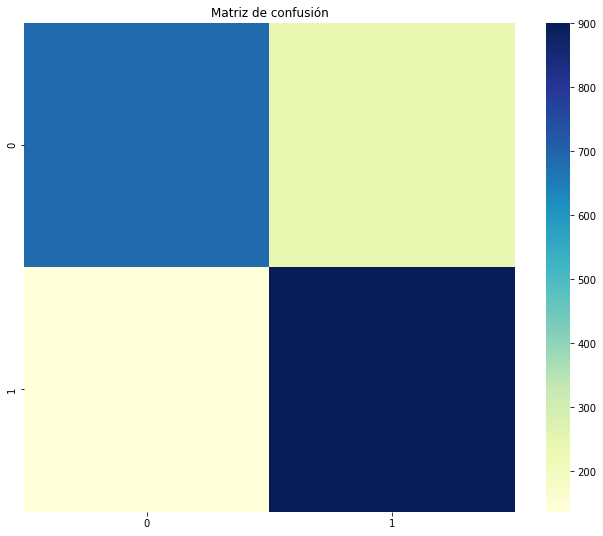

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))
plt.title('Matriz de confusión')
sns.heatmap(confusion_matrix(y_test, pipe.predict(X_test)), cmap='YlGnBu')
plt.show()